# Test new model

In [1]:
import torch
import torch.nn as nn 
from utils import get_mse_data, get_mse_train_loader

## Data

In [2]:
num_users, num_items, users_train, items_train, ratings_train, users_test, items_test, ratings_test, train_candidates, test_candidates = get_mse_data()

In [3]:
train_loader = get_mse_train_loader(users_train, items_train, ratings_train, shuffle=True)

In [4]:
len(train_loader)

98

## Model Config

In [5]:
from gcn.models import BiasMF
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 32
model = BiasMF(num_users, num_items, n_factors)
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 32, learning_rate: 0.01, weight_decay: 1e-05


## Train

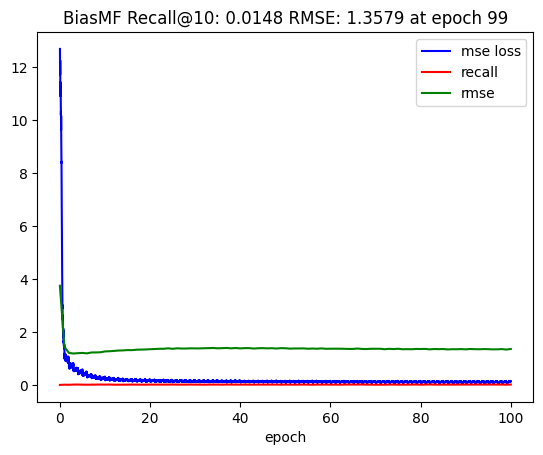

BiasMF Recall@10: 0.0148 RMSE: 1.3579 at epoch 99


In [6]:
from gcn.train import evaluate_ranking, evaluate_rating
from gcn.visualize import Animator
ani = Animator()
num_epochs = 100
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
rmse_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    rmse = evaluate_rating(
        model,
        users_test, 
        items_test, 
        ratings_test
    )
    rmse_list.append(rmse)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users, items, ratings = values[0].to(device), values[1].to(device), values[2].to(device)
        # Forward pass
        scores = model(users, items)
        loss = loss_fn(scores, ratings.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        rmse = evaluate_rating(
            model,
            users_test, 
            items_test, 
            ratings_test
        )
        rmse_list.append(rmse)
        epoch_list.append(epoch+1)


    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.plot(epoch_list, rmse_list, color='g', label='rmse')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'BiasMF Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'BiasMF Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')

ani.close()

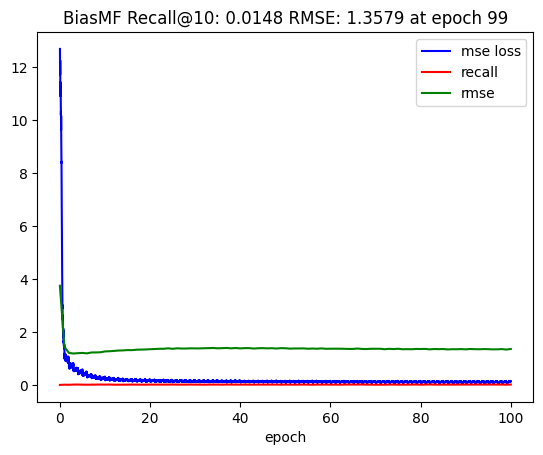

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.plot(epoch_list, rmse_list, color='g', label='rmse')
plt.xlabel("epoch")
plt.legend()
plt.title(f'BiasMF Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
plt.savefig(f'./images/BiasMF Embed_dim: {n_factors} Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}.png')
plt.show()

In [8]:
recall_list

[0.0,
 0.00819672131147541,
 0.004918032786885246,
 0.013114754098360656,
 0.014754098360655738,
 0.009836065573770493,
 0.00819672131147541,
 0.009836065573770493,
 0.011475409836065573,
 0.014754098360655738,
 0.011475409836065573,
 0.014754098360655738,
 0.00819672131147541,
 0.00819672131147541,
 0.009836065573770493,
 0.009836065573770493,
 0.013114754098360656,
 0.011475409836065573,
 0.009836065573770493,
 0.009836065573770493,
 0.013114754098360656,
 0.011475409836065573,
 0.013114754098360656,
 0.011475409836065573,
 0.011475409836065573,
 0.014754098360655738,
 0.011475409836065573,
 0.011475409836065573,
 0.011475409836065573,
 0.014754098360655738,
 0.011475409836065573,
 0.011475409836065573,
 0.00819672131147541,
 0.013114754098360656,
 0.011475409836065573,
 0.013114754098360656,
 0.009836065573770493,
 0.014754098360655738,
 0.013114754098360656,
 0.011475409836065573,
 0.011475409836065573,
 0.013114754098360656,
 0.011475409836065573,
 0.009836065573770493,
 0.0131147

In [9]:
rmse_list

[3.745329173229601,
 1.438387803953996,
 1.2082571082353024,
 1.18626691140922,
 1.1991440442204464,
 1.207627281999421,
 1.1915130567359526,
 1.2251488867607643,
 1.226959115796795,
 1.23314489566087,
 1.2653068330938881,
 1.27181791510168,
 1.2842556658993536,
 1.298630411114583,
 1.3041216142731678,
 1.315597874595106,
 1.3139082755759217,
 1.3296829510441752,
 1.3344106146819068,
 1.3387242748022097,
 1.3482959500628908,
 1.355456701219639,
 1.3645169142460678,
 1.365365825649843,
 1.3824619344537568,
 1.364005653271748,
 1.3827497823684347,
 1.3741497098355764,
 1.3743721655677201,
 1.3823806605645277,
 1.3792018411459217,
 1.378991575545926,
 1.3855096838374183,
 1.3892481127416023,
 1.3950328192046308,
 1.3827906461378916,
 1.3890254647603206,
 1.3960645351331036,
 1.382026966491582,
 1.394469657841403,
 1.3796846175892703,
 1.3898738589786017,
 1.3899410151583795,
 1.3742994778133395,
 1.3850341880792825,
 1.3891970557489453,
 1.3811091476360662,
 1.386951609657795,
 1.37474456

In [10]:
# max(recall_list), min(rmse_list) 
print(f'BiasMF Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')
print(f'BiasMF Min RMSE: {min(rmse_list):.4f} at epoch {rmse_list.index(min(rmse_list))}')

BiasMF Max Recall@10: 0.0164 at epoch 67
BiasMF Min RMSE: 1.1863 at epoch 3
